# Environnement

In [ ]:
!pip install opencv-contrib-python==4.4.0.44
!pip install tqdm
!pip install Keras-Applications
!pip install -U yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.7 MB 1.4 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
from google.colab import drive
from yellowbrick.text import TSNEVisualizer
# from sklearn.manifold import TSNE
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.decomposition import PCA
# from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
# import tensorflow as tf
import tensorflow.keras.preprocessing.image as image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers
import PIL
from PIL import ImageFilter
from tensorflow import keras
import keras_applications as ka
import pathlib
import progressbar
import numpy as np
import cv2 as cv
import os
import tensorflow_hub as hub
import plotly.express as px
import matplotlib.cm as cm
import pandas as pd
import nltk
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import sys
import time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
original_data_path = '/content/gdrive/MyDrive/Flipkart/Images/'

# Exploration

In [ ]:
liste_img_os = os.listdir(original_data_path)
liste_img_os[0:10]

['c5590e238d44b370337624f5987fb9b8.jpg',
 'cab75cad4b3a3c593c753a1759df28e2.jpg',
 'b92e13d5ef945d086fd4f42b95bc04ac.jpg',
 'aab46b84f70cc6774afaafe1d6035de3.jpg',
 'b7ef3e6ec248f17f3a6a4697120ddb96.jpg',
 'f69bef5db54cb4c83b2aa8d0ce829d4e.jpg',
 'acd2f21d63ac0bbed4d52e6010d9460b.jpg',
 'b46d7b8e6826ad4c8b40a991da0f54d7.jpg',
 'ffbf3794aa8cb6bb8d3f313d0a549a09.jpg',
 'ce2f67c3365846170cb709784d87e45b.jpg']

In [ ]:
dataset = pd.read_csv('/content/gdrive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv', sep=',')
dataset.iloc[0:3,:]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


On a un fichier contenant des éléments classiques d'item pour une entreprise de retail, allant de l'ID au prix en passant par une description etc...

Les éléments importants pour cette étude sont:

*   product_category_tree (catégories des produits)
*   image (le titre de l'image)
*   description (la description du produit)




## Nettoyage des catégories

In [ ]:
def clean_it(x):
  t = x.index('"')
  p = x.index('>')
  x = x[t+1:p-1]
  return(x)

dataset.loc[:,"product_category_tree"] = dataset.loc[:,"product_category_tree"].apply(lambda x: clean_it(x))
dataset.loc[0:3,"product_category_tree"]

0    Home Furnishing
1          Baby Care
2          Baby Care
3    Home Furnishing
Name: product_category_tree, dtype: object

In [ ]:
data = dataset.loc[:,["image", "product_category_tree"]]

In [ ]:
liste_img = data.loc[:, "image"].values
liste_img

array(['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
       '7b72c92c2f6c40268628ec5f14c6d590.jpg',
       '64d5d4a258243731dc7bbb1eef49ad74.jpg', ...,
       '5912e037d12774bb73a2048f35a00009.jpg',
       'c3edc504d1b4f0ba6224fa53a43a7ad6.jpg',
       'f2f027ad6a6df617c9f125173da71e44.jpg'], dtype=object)

In [ ]:
def common_elements(list1, list2):
    return [element for element in list1 if element in list2]

l = common_elements(liste_img, liste_img_os)
len(l)

1050

On compte 1050 produits contenant des images et catégories

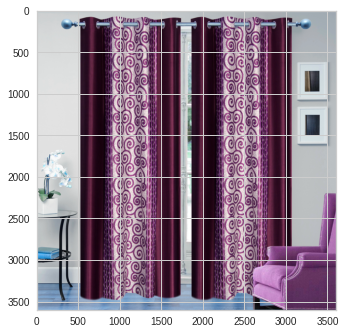

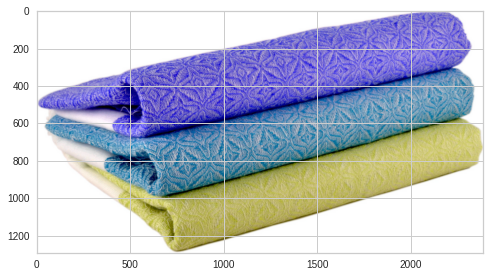

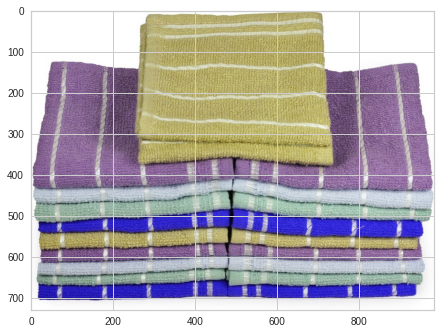

In [ ]:
for i in range(0,3):
  path = original_data_path+liste_img[i]
  image = cv.imread(path)
  plt.imshow(image)
  plt.show()

# SIFT

## Test visualisation descripteurs

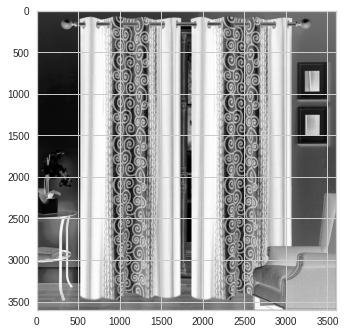

In [ ]:
sift = cv.SIFT_create() 
image = cv.imread(original_data_path+liste_img[0],0) 
image = cv.equalizeHist(image) 
plt.imshow(image)

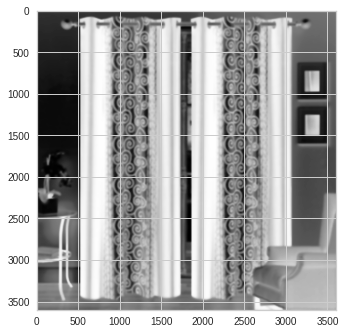

In [ ]:
image_test = image
cv.fastNlMeansDenoising(image, image_test, 200, 7, 21)
plt.imshow(image_test)

Descripteurs :  (37629, 128)

[[ 6.  0.  0. ...  5.  1. 10.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 5.  3.  2. ...  0.  0.  2.]
 ...
 [52. 18.  3. ...  0.  0.  0.]
 [70. 27.  6. ...  0.  0.  4.]
 [65. 18.  4. ...  0.  0.  1.]]


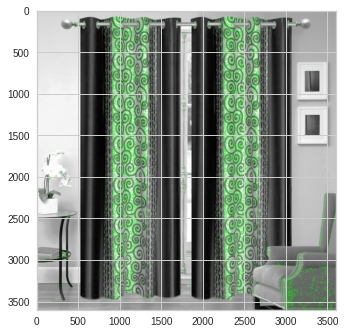

In [ ]:
sift = cv.SIFT_create() 
image = cv.imread(original_data_path+liste_img[0],0) 
image = cv.equalizeHist(image) 
image_nonoise = image
cv.fastNlMeansDenoising(image, image_nonoise, 20, 7, 21)

kp, des = sift.detectAndCompute(image, None)
img=cv.drawKeypoints(image,kp,image, (0,255,0))

plt.imshow(img)

print("Descripteurs : ", des.shape)
print()
print(des)

In [ ]:
data = dataset.loc[:,["image", "product_category_tree"]]
data

,image,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


## Descripteurs

Création et stockage des descripteurs

In [ ]:
sift_keypoints = []  

for i, i_mage in tqdm(data.iterrows(), total=data.shape[0]): #range(len(liste_img)): #tqdm(range(len(liste_img))): #tqdm(range(len(liste_img))):
    image_grey = cv.imread(original_data_path+i_mage["image"],0)
    image_greyqual = cv.equalizeHist(image_grey)   
    image_nonoise = image_greyqual
    cv.fastNlMeansDenoising(image, image_nonoise, 20, 7, 21)
    kp, des = sift.detectAndCompute(image_nonoise, None)
    sift_keypoints.append(des)
    # data.loc[i_mage["image"], "sift_keypoints"] = des
    #data.loc[image == liste_img[int(i_mage)], "sift_keypoints"] = des
    # print(des)
    # data.loc[data["image"] == liste_img[int(i_mage)], ["sift_keypoints"]] = des
    # print("banana")

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
sift_keypoints_all.shape

100%|██████████| 1050/1050 [32:34<00:00,  1.86s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


(8954261, 128)

In [ ]:
sift_keypoints_by_img

array([array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
              [ 0.,  0.,  0., ...,  0.,  0.,  1.],
              [ 0.,  1.,  4., ...,  2.,  1.,  1.],
              ...,
              [17., 30., 27., ...,  3., 25., 49.],
              [ 7., 71., 34., ...,  0.,  0., 38.],
              [ 0.,  0.,  0., ..., 32.,  1.,  3.]], dtype=float32),
       array([[ 85., 113.,  31., ...,   0.,   0.,   0.],
              [ 29.,  80.,  73., ...,   0.,   0.,   0.],
              [ 10.,  67., 115., ...,   0.,   0.,  22.],
              ...,
              [  0.,   0.,   0., ...,   0.,   0.,  13.],
              [ 40.,   0.,   0., ...,   0.,   0.,  51.],
              [ 37.,   1.,   0., ...,   0.,   0.,   0.]], dtype=float32),
       array([[117.,  56.,   1., ...,   1.,   2.,   0.],
              [ 30.,   2.,  15., ...,   1.,   2.,   1.],
              [ 14.,  19.,   9., ...,   1.,   1.,   1.],
              ...,
              [ 57., 127.,   9., ...,   1.,   1.,   4.],
              [ 16.,   7.,   6., 

In [ ]:
np.save("sift_keypoints_all", sift_keypoints_all)

In [ ]:
np.save("sift_keypoints_by_img", sift_keypoints_by_img)

## Kmeans Mini Batch

Création des clusters autour de ces descripteurs, ceux-ci nous serviront de features.

In [ ]:
n_clusters_sqrt = int(round(np.sqrt(len(sift_keypoints_all)),0))
minikmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters_sqrt, init_size=3*n_clusters_sqrt, random_state=0)
minikmeans.fit(sift_keypoints_all)

MiniBatchKMeans(init_size=8985, n_clusters=2995, random_state=0)

On trouve plus de 3000 feature-like

## Histogram

In [ ]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [ ]:
hist_vectors_sift=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist_sift = build_histogram(minikmeans, image_desc, i) #calculates the histogram
    hist_vectors_sift.append(hist_sift) #histogram is the feature vector

im_features_sift = np.asarray(hist_vectors_sift)



0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
im_features_sift[0:3]

array([[6.83713934e-05, 0.00000000e+00, 2.73485574e-04, ...,
        0.00000000e+00, 1.16231369e-03, 0.00000000e+00],
       [3.35774695e-04, 1.67887348e-04, 4.40704287e-04, ...,
        2.09859184e-05, 1.88873266e-04, 7.13521227e-04],
       [5.62050360e-04, 2.24820144e-04, 0.00000000e+00, ...,
        0.00000000e+00, 6.74460432e-04, 6.74460432e-04]])

In [ ]:
im_features_sift.shape

(1050, 2995)

In [ ]:
im_features_sift[0]

array([6.83713934e-05, 0.00000000e+00, 2.73485574e-04, ...,
       0.00000000e+00, 1.16231369e-03, 0.00000000e+00])

In [ ]:
np.save("im_features_sift", im_features_sift)

## PCA

On filtre les features conservant le plus d'inertie

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features_sift.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_sift= pca.fit_transform(im_features_sift)
print("Dimensions dataset après réduction PCA : ", feat_pca_sift.shape)

Dimensions dataset avant réduction PCA :  (1050, 2995)
Dimensions dataset après réduction PCA :  (1050, 741)


Et on passe de 3000 à 741 éléments étudiables

## TSNE

Nous allons utiliser le tsne pour visualiser sur ces dimensions

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_sift = tsne.fit_transform(feat_pca_sift)

df_tsne_sift = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_sift["class"] = data["product_category_tree"]
print(df_tsne_sift.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


### TSNE Catégories

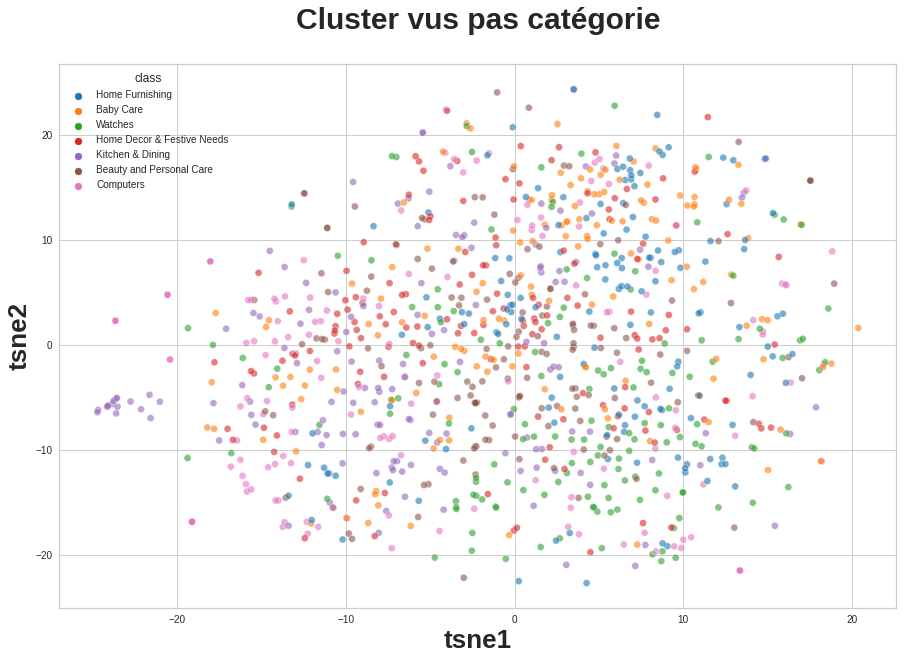

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    x="tsne1", y="tsne2", 
    hue="class", 
    data=df_tsne_sift, 
    legend="auto",
    palette=sns.color_palette('tab10', n_colors=7), 
    s=50, alpha=0.6)

plt.title('Cluster vus pas catégorie', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
# plt.legend(prop={'size': 20}) 

plt.show()

Lorsque l'on observe par classes, on a un ensemble difus et non distinguable 

### TSNE Clusters

On observe les clusters formés sur les feature-like

In [ ]:
cls_sift = cluster.KMeans(n_clusters=7)
cls_sift.fit(feat_pca_sift)

df_tsne_sift["cluster"] = cls_sift.labels_
print(df_tsne_sift.shape)

(1050, 4)


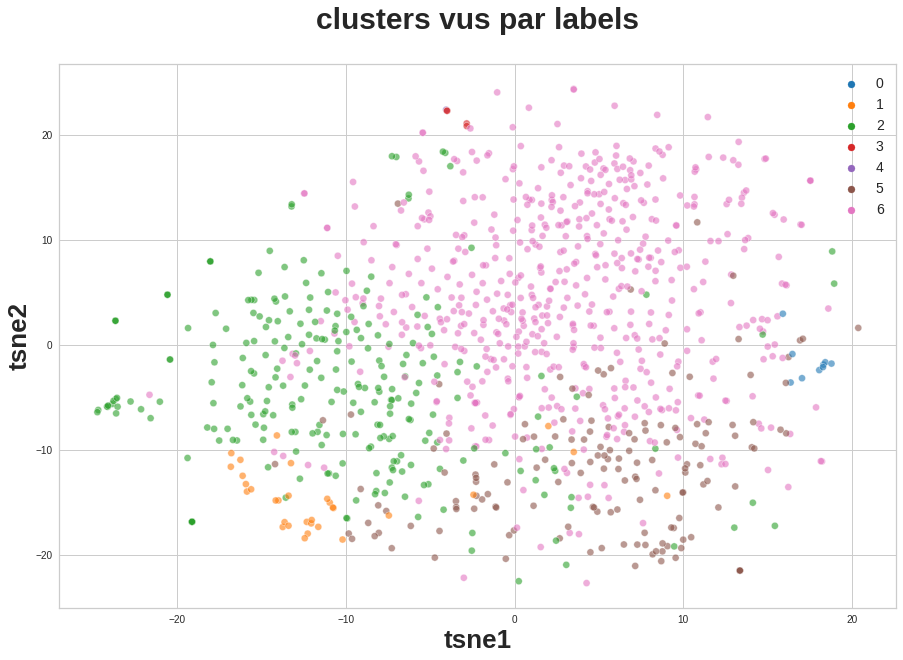

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), 
    s=50, alpha=0.6,
    data=df_tsne_sift,
    legend="auto")

plt.title('clusters vus par labels', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Ceux-ci sont très peu distincts.

## Score ARI

In [ ]:
def clusterit(x, l):
  return(np.where(l==x)[0][0])

lcat = data.loc[:,"product_category_tree"].unique() 

data.loc[:,"cluster_category"] = data.loc[:,"product_category_tree"].apply(lambda x: clusterit(x, lcat))


In [ ]:
cls_sift.labels_

array([6, 6, 6, ..., 6, 6, 6], dtype=int32)

In [ ]:
data["cluster_labels"] = cls_sift.labels_

In [ ]:
data

,image,product_category_tree,cluster_category,cluster_labels
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0,6
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,1,6
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,1,6
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,0,6
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,0,6
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,1,6
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,1,5
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,1,6
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,1,6


Score ARI global

In [ ]:
category = data["cluster_category"]
print("ARI : ", metrics.adjusted_rand_score(category, cls_sift.labels_))

ARI :  0.06015287387748692


On a un score de ARI assez faible.

Score ARI par catégories

In [ ]:
arilist = []
for i in lcat:
  k = metrics.adjusted_rand_score(data.loc[data["product_category_tree"] == i,"cluster_category"], 
                                  data.loc[data["product_category_tree"] == i,"cluster_labels"])
  arilist.append(k)

arilist

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Distribution des catégories par clusters

In [ ]:
data.iloc[0:1,:]

,image,product_category_tree,cluster_category,cluster_labels
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0,6


Pour le cluster 0


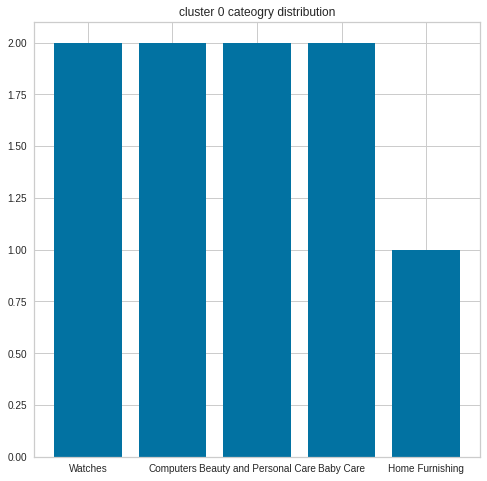

Pour le cluster 1


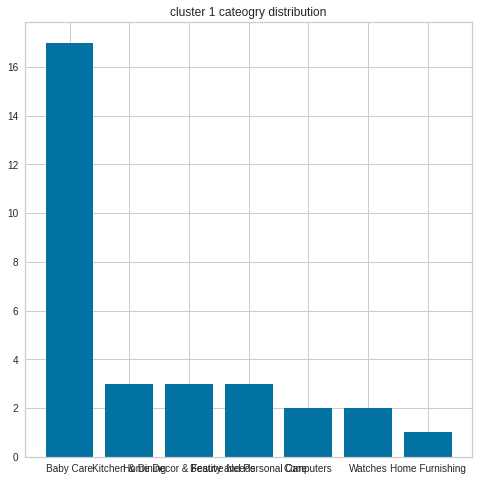

Pour le cluster 2


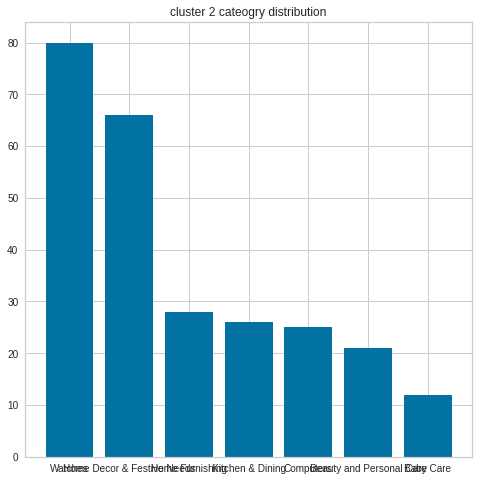

Pour le cluster 3


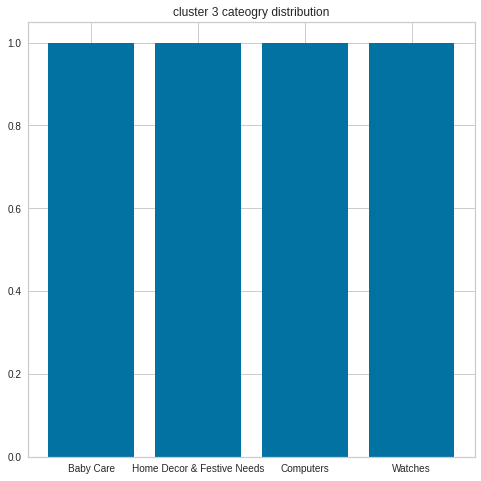

Pour le cluster 4


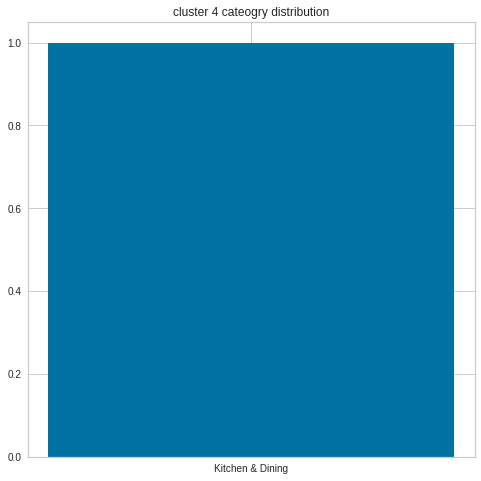

Pour le cluster 5


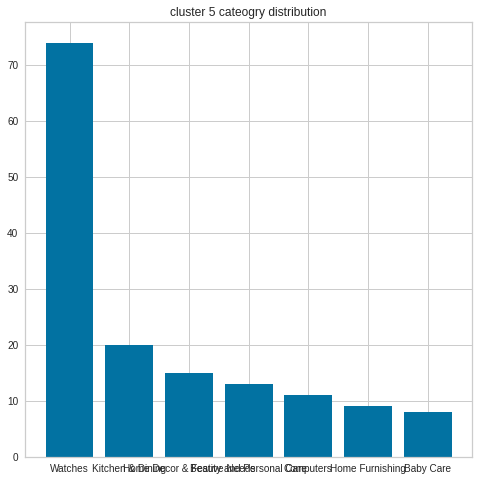

Pour le cluster 6


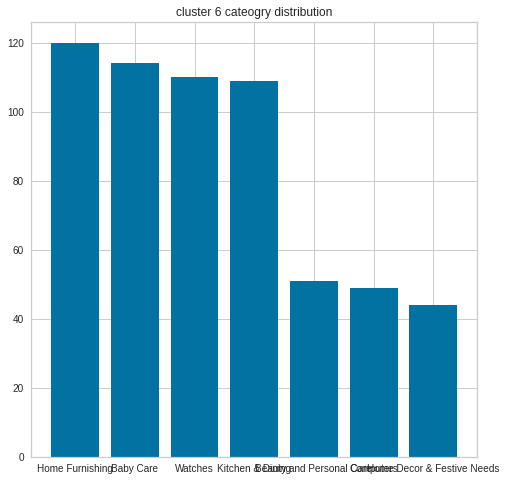

In [ ]:
for i in range(0,7):
  print("Pour le cluster "+str(i))
  l_category = data.loc[data["cluster_labels"]==i, "product_category_tree"].unique()
  plt.figure(figsize=(8,8))
  plt.bar(l_category,
          data.loc[data["cluster_labels"]==i, "product_category_tree"].value_counts())
  plt.title(label="cluster "+str(i)+" cateogry distribution")
  plt.show()

L'heterogénéité de chacun des clusters est flagrante.

# ORB

### Test visualisation descripteurs

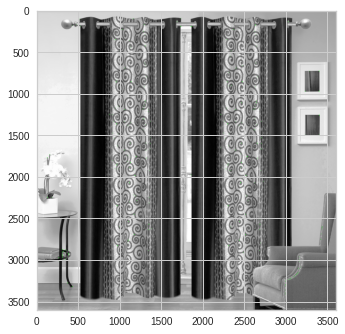

Descripteurs :  (500, 32)

[[ 41 189  59 ... 192 198 171]
 [ 53 199 157 ... 123 129  32]
 [  9 112  17 ... 178  67 169]
 ...
 [ 39  98  96 ... 175 122 197]
 [184  53 108 ...  77 222 211]
 [ 16 196 150 ...  80  35 138]]


In [ ]:
orb = cv.ORB_create()
image = cv.imread(original_data_path+liste_img[0],0) 
image = cv.equalizeHist(image) 
# image = cv.fastNlMeansDenoising(image)

kp, des = orb.detectAndCompute(image, None)
img=cv.drawKeypoints(image,kp,image, (0,255,0))

plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)



## Descripteurs

Calcul et stockage des descripteurs

In [ ]:
orb_keypoints = []  

for i, i_mage in tqdm(data.iterrows(), total=data.shape[0]): #range(len(liste_img)): #tqdm(range(len(liste_img))): #tqdm(range(len(liste_img))):
    image_grey = cv.imread(original_data_path+i_mage["image"],0)
    image_greyqual = cv.equalizeHist(image_grey)   
    image_nonoise = image_greyqual
    cv.fastNlMeansDenoising(image, image_nonoise, 30, 7, 21)
    kp, des = orb.detectAndCompute(image_greyqual, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all = np.concatenate(orb_keypoints_by_img, axis=0)
orb_keypoints_all.shape

100%|██████████| 1050/1050 [19:50<00:00,  1.13s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


(520153, 32)

## Kmeans Mini Batch

On applique un minibatchkmeans afin de créer des featurelike via des clusters de descripteurs.

In [ ]:
n_clusters_sqrt_orb = int(round(np.sqrt(len(orb_keypoints_all)),0))
minikmeans_orb = cluster.MiniBatchKMeans(n_clusters=n_clusters_sqrt_orb, init_size=3*n_clusters_sqrt_orb, random_state=0)
minikmeans_orb.fit(orb_keypoints_all)

MiniBatchKMeans(init_size=2163, n_clusters=721, random_state=0)

On en ressort 721 clusters de descripteurs

## Histogram

In [ ]:
hist_vectors_orb=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist_orb = build_histogram(minikmeans_orb, image_desc, i) #calculates the histogram
    hist_vectors_orb.append(hist_orb) #histogram is the feature vector

im_features_orb = np.asarray(hist_vectors_orb)

0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
im_features_orb.shape

(1050, 721)

## PCA

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features_orb.shape)
pca_orb = decomposition.PCA(n_components=0.99)
feat_pca_orb= pca_orb.fit_transform(im_features_orb)
print("Dimensions dataset après réduction PCA : ", feat_pca_orb.shape)

Dimensions dataset avant réduction PCA :  (1050, 721)
Dimensions dataset après réduction PCA :  (1050, 576)


On passe de 700+ featurelike à 570+

## TSNE

On va utiliser un tsne pour observer le comportenement de nos items dans ces dimensions

In [ ]:
tsne_orb = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_orb = tsne_orb.fit_transform(feat_pca_orb)

df_tsne_orb = pd.DataFrame(X_tsne_orb[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_orb["class"] = data["product_category_tree"]
print(df_tsne_orb.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


### TSNE Catégories

Observons par catégories

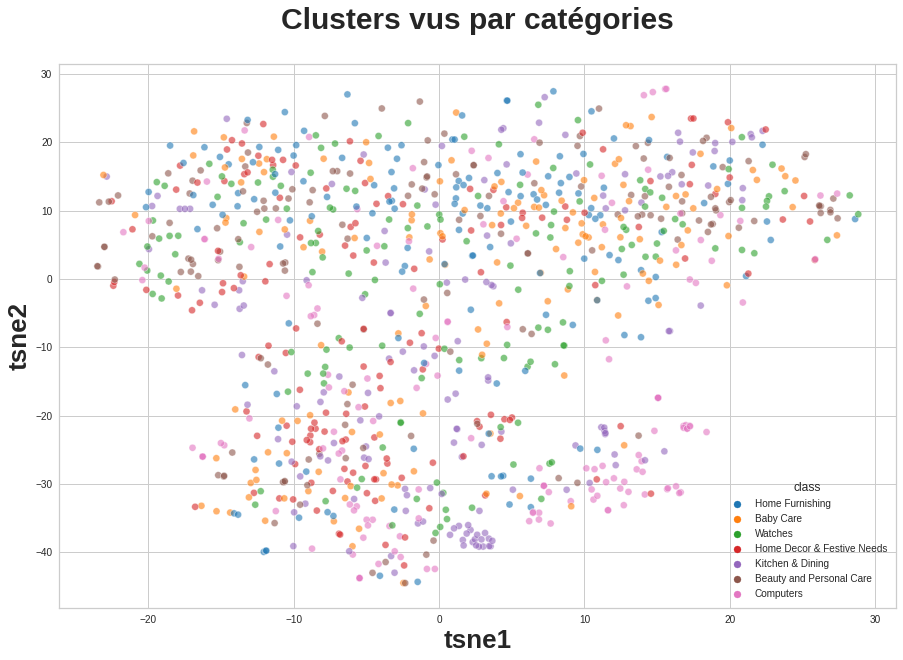

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", 
    hue="class", 
    data=df_tsne_orb, 
    legend="auto",
    palette=sns.color_palette('tab10', n_colors=7), 
    s=50, alpha=0.6)

plt.title('Clusters vus par catégories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
# plt.legend(prop={'size': 14}) 

plt.show()

Les éléments sont diffus et non distinguables

### TSNE Clusters

En observant les clusters maintenant

In [ ]:
cls_orb = cluster.KMeans(n_clusters=7)
cls_orb.fit(feat_pca_orb)

df_tsne_orb ["cluster"] = cls_orb.labels_
print(df_tsne_orb.shape)

(1050, 4)


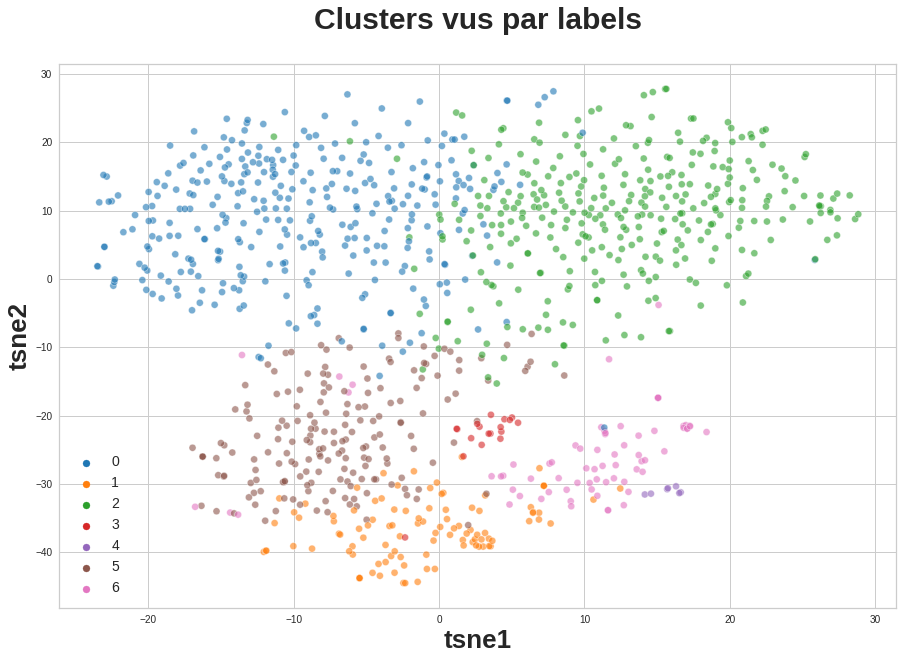

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_orb,
    legend="auto")

plt.title('Clusters vus par labels', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Ceux-ci sont assez facilement distinguables sans pour autant pouvoir facilement les segmenter.

## Score ARI

In [ ]:
data["orb_cluster_labels"] = cls_orb.labels_

In [ ]:
data.iloc[0:2,:]

,image,product_category_tree,cluster_category,cluster_labels,orb_cluster_labels
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0,6,0
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,1,6,0


Score ARI global

In [ ]:
category = data["cluster_category"]
print("ARI : ", metrics.adjusted_rand_score(category, cls_orb.labels_))

ARI :  0.022478559860262395


Nous obtenons un score de similarité assez bas.

Score ARI par catégories

In [ ]:
arilist = []
for i in lcat:
  k = metrics.adjusted_rand_score(data.loc[data["product_category_tree"] == i,"cluster_category"], 
                                  data.loc[data["product_category_tree"] == i,"orb_cluster_labels"])
  arilist.append(k)

arilist

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Distribution des catégories par clusters

Pour le cluster 0


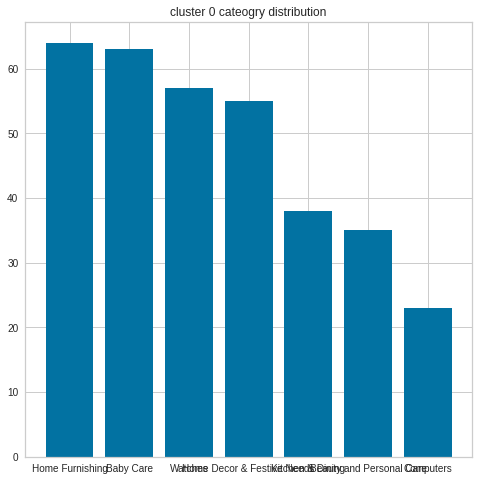

Pour le cluster 1


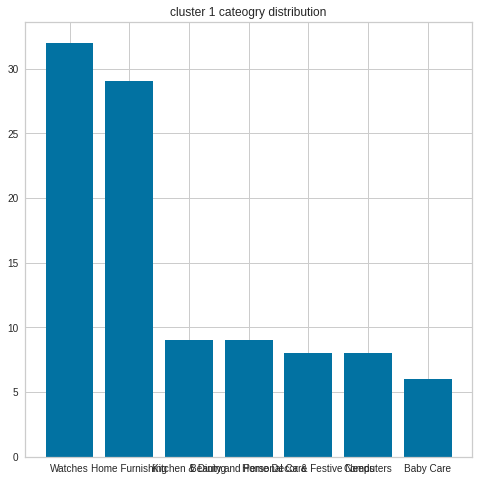

Pour le cluster 2


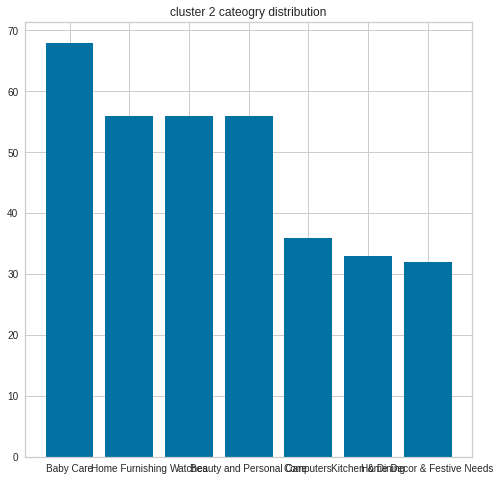

Pour le cluster 3


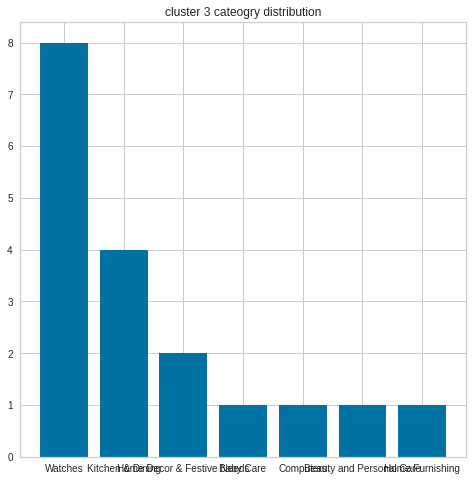

Pour le cluster 4


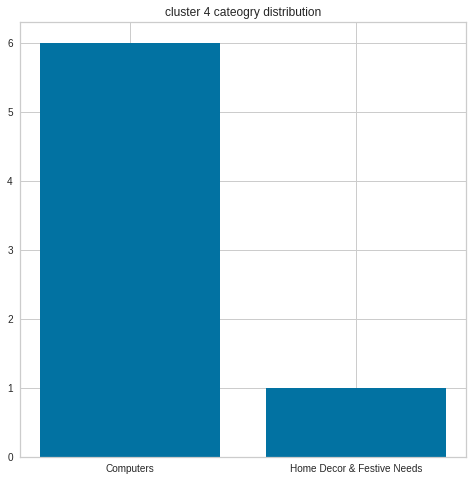

Pour le cluster 5


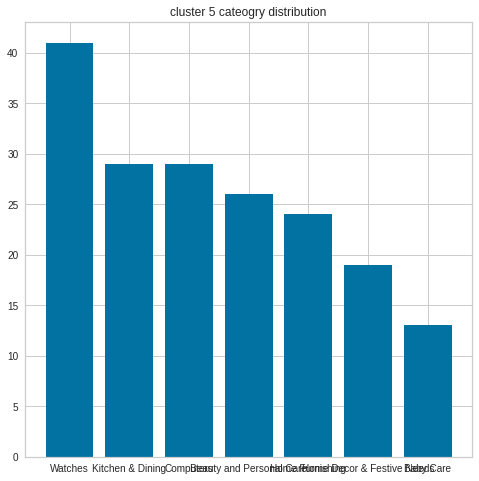

Pour le cluster 6


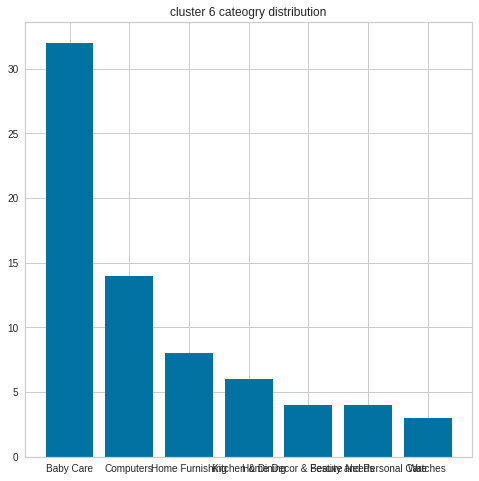

In [ ]:
for i in range(0,7):
  print("Pour le cluster "+str(i))
  l_category = data.loc[data["orb_cluster_labels"]==i, "product_category_tree"].unique()
  plt.figure(figsize=(8,8))
  plt.bar(l_category,
          data.loc[data["orb_cluster_labels"]==i, "product_category_tree"].value_counts())
  plt.title(label="cluster "+str(i)+" cateogry distribution")
  plt.show()

# RESNET50

## Keras set up and testing

On fait des tests.

In [ ]:
#original_data_path+liste_img[0]
# data_dir = keras.utils.get_file(original_data_path+liste_img[0], origin=original_data_path, untar=False)
data_dir = keras.utils.get_file(original_data_path, origin=original_data_path, untar=False)

data_dir = pathlib.Path(data_dir)

In [ ]:
data_dir

PosixPath('/content/gdrive/MyDrive/Flipkart/Images')

In [ ]:
model = ResNet50(weights='imagenet')

img_path = original_data_path+liste_img[0]
img = cv.imread(img_path) 
img_nonoise = img
cv.fastNlMeansDenoisingColored(img, img_nonoise, 10, 10, 7, 21) 
# img_nonoise = image.load_img(img_nonoise, target_size=(224, 224))

img_nonoise = cv.resize(img_nonoise, (224, 224))
x = image.img_to_array(img_nonoise)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02840245', 'binder', 0.6124281), ('n04209239', 'shower_curtain', 0.31031257), ('n04550184', 'wardrobe', 0.019394685)]


In [ ]:
model = ResNet50(weights='imagenet')

In [ ]:
for i in range(0,5):
  img_path = original_data_path+liste_img[i]
  img = cv.imread(img_path) 
  
  img_y_cr_cb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
  y, cr, cb = cv.split(img_y_cr_cb)

  # Applying equalize Hist operation on Y channel.
  y_eq = cv.equalizeHist(y)

  img_y_cr_cb_eq = cv.merge((y_eq, cr, cb))
  img_rgb_eq = cv.cvtColor(img_y_cr_cb_eq, cv.COLOR_YCR_CB2BGR)


  img_nonoise = img_rgb_eq
  cv.fastNlMeansDenoisingColored(img, img_nonoise, 10, 10, 7, 21) 
# img_nonoise = image.load_img(img_nonoise, target_size=(224, 224))

  img_nonoise = cv.resize(img_nonoise, (224, 224))
  # img = image.load_img(img_path, target_size=(224, 224))
  plt.imshow(img)
  plt.show()
  plt.imshow(img_nonoise)
  plt.show()
  x = image.img_to_array(img_nonoise)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('Predicted:', decode_predictions(preds, top=3)[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_36[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
preds.shape

(1, 1000)

## Personnal Keras

### SetUp du Model

In [ ]:
from keras.models import Model
retail_input = layers.Input(shape=(224, 224, 3))
retail_output = layers.Input(shape=(7, 7, 2048))
# model = ResNet50(weights='imagenet', include_top=False)
model = ResNet50(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3))
# model = Model(inputs=retail_input, outputs=retail_output)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_39[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Extraction des features

In [ ]:
retail_list = []

# for i, i_mage in tqdm(data.iloc[0:50,:].iterrows(), total=data.iloc[0:50,:].shape[0]):
for i, i_mage in tqdm(data.iterrows(), total=data.shape[0]):
# for i in range(0,50):
  # img_path = original_data_path+liste_img[i]
  img_path = original_data_path+i_mage["image"]
  img = cv.imread(img_path) 

  img_y_cr_cb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
  y, cr, cb = cv.split(img_y_cr_cb)

  # Applying equalize Hist operation on Y channel.
  y_eq = cv.equalizeHist(y)

  img_y_cr_cb_eq = cv.merge((y_eq, cr, cb))
  img_rgb_eq = cv.cvtColor(img_y_cr_cb_eq, cv.COLOR_YCR_CB2BGR)


  img_nonoise = img_rgb_eq
  cv.fastNlMeansDenoisingColored(img, img_nonoise, 10, 10, 7, 21) 
  # img = image.load_img(img_path, target_size=(224, 224, 3))
  # plt.imshow(img)
  # plt.show()
  
  img_nonoise = cv.resize(img_nonoise, (224, 224))
  x = image.img_to_array(img_nonoise)
  
  x = preprocess_input(x)
  x = np.expand_dims(x, axis=(0))
  feature = model.predict(x).reshape(x.shape[0],-1)
  retail_list.append(feature)
  

retail_list_img = np.asarray(retail_list)
retail_list_all = np.concatenate(retail_list_img, axis=0)
print(feature.shape)



100%|██████████| 1050/1050 [12:52<00:00,  1.36it/s]


(1, 100352)


In [ ]:
#old with bruit
# retail_list = []

# # for i, i_mage in tqdm(data.iloc[0:50,:].iterrows(), total=data.iloc[0:50,:].shape[0]):
# for i, i_mage in tqdm(data.iterrows(), total=data.shape[0]):
# # for i in range(0,50):
#   # img_path = original_data_path+liste_img[i]
#   img_path = original_data_path+i_mage["image"]

#   img = image.load_img(img_path, target_size=(224, 224, 3))
#   # plt.imshow(img)
#   # plt.show()
  
#   x = image.img_to_array(img)
  
#   x = preprocess_input(x)
#   x = np.expand_dims(x, axis=(0))
#   feature = model.predict(x).reshape(x.shape[0],-1)
#   retail_list.append(feature)
  

# retail_list_img = np.asarray(retail_list)
# retail_list_all = np.concatenate(retail_list_img, axis=0)
# print(feature.shape)



In [ ]:
print(retail_list_all.shape)

(1050, 100352)


In [ ]:
retail_list_img[1].shape

(1, 100352)

### PCA

In [ ]:
print("Dimensions dataset avant réduction PCA : ", retail_list_all.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_resnet = pca.fit_transform(retail_list_all)
print("Dimensions dataset après réduction PCA : ", feat_pca_resnet.shape)

Dimensions dataset avant réduction PCA :  (1050, 100352)
Dimensions dataset après réduction PCA :  (1050, 975)


### KMeans

In [ ]:
n_clusters = 7

minikmeans = KMeans(n_clusters=n_clusters, 
                            init = "k-means++", 
                            random_state=0)
minikmeans.fit(feat_pca_resnet)

KMeans(n_clusters=7, random_state=0)

### TSNE

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_resnet = tsne.fit_transform(feat_pca_resnet)

df_tsne_resnet = pd.DataFrame(X_tsne_resnet[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_resnet["class"] = data["product_category_tree"]
print(df_tsne_resnet.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1050, 3)


#### TSNE Catégories

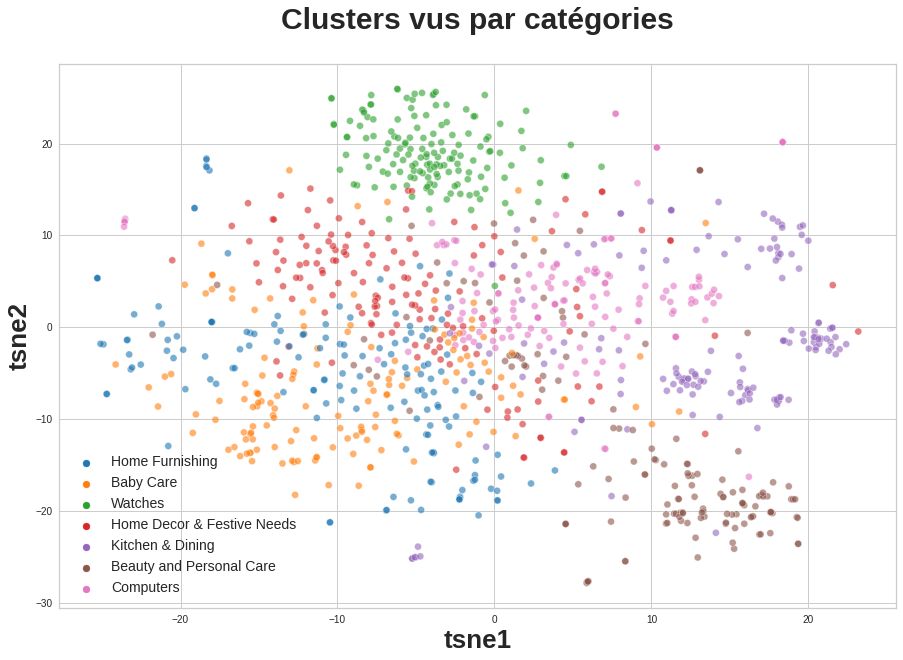

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), 
    s=50, alpha=0.6,
    data=df_tsne_resnet,
    legend="auto")

plt.title('Clusters vus par catégories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#### TSNE Clusters

In [ ]:
cls_tsne = KMeans(n_clusters=7, init = "k-means++", random_state=0)
cls_tsne.fit(feat_pca_resnet)
# cls_tsne.fit(X_tsne_resnet[0:50])

df_tsne_resnet["cluster"] = cls_tsne.labels_
print(df_tsne_resnet.shape)

(1050, 4)


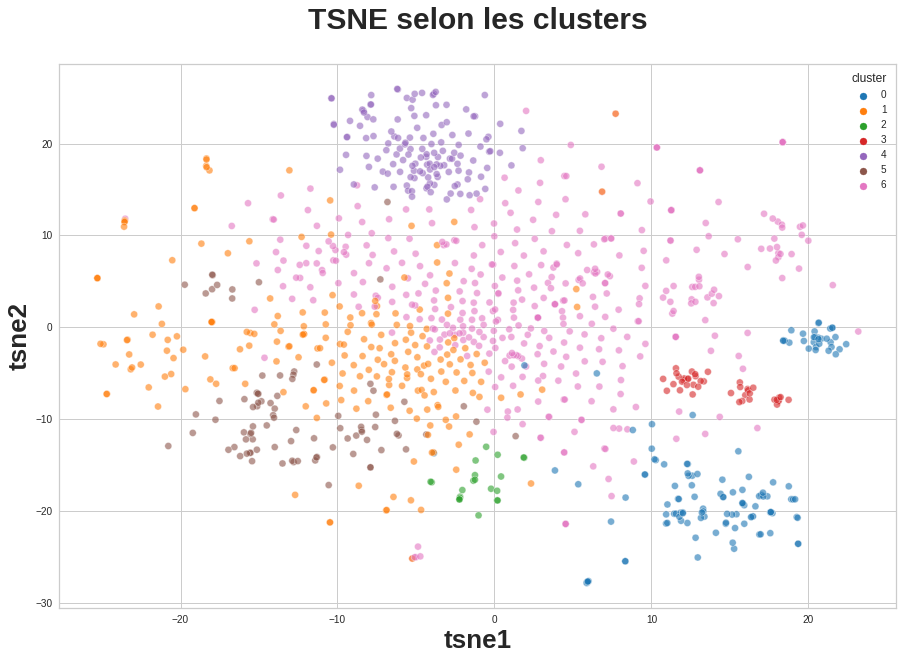

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_resnet,
    legend="auto")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
# plt.legend(prop={'size': 14}) 

plt.show()

On a des clusters assez distincts mais peu faciles à segmenter

### Score ARI

#### Sur base PCA

In [ ]:
cls_tsne = KMeans(n_clusters=7, init = "k-means++", random_state=0)
cls_tsne.fit(feat_pca_resnet)

KMeans(n_clusters=7, random_state=0)

In [ ]:
data["resnet_cluster_labels"] = cls_tsne.labels_

Score ARI global

In [ ]:
labels = data["product_category_tree"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls_tsne.labels_))

ARI :  0.32334168053878687


Score ARI par catégories

In [ ]:
data["resnet_cluster_labels"] = cls_tsne.labels_

In [ ]:
arilist = []
for i in lcat:
  k = metrics.adjusted_rand_score(data.loc[data["product_category_tree"] == i,"cluster_category"], 
                                  data.loc[data["product_category_tree"] == i,"resnet_cluster_labels"])
  arilist.append(k)

arilist

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### Sur base PCA+ TSNE

In [ ]:
cls_tsne = KMeans(n_clusters=7, init = "k-means++", random_state=0)
cls_tsne.fit(X_tsne_resnet)

KMeans(n_clusters=7, random_state=0)

In [ ]:
print("ARI : ", metrics.adjusted_rand_score(labels, cls_tsne.labels_))

ARI :  0.3335700829909875


Score ARI par catégories

In [ ]:
data["resnet_cluster_labels"] = cls_tsne.labels_

In [ ]:
arilist = []
for i in lcat:
  k = metrics.adjusted_rand_score(data.loc[data["product_category_tree"] == i,"cluster_category"], 
                                  data.loc[data["product_category_tree"] == i,"resnet_cluster_labels"])
  arilist.append(k)

arilist

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Le score est bien meilleur en sorti de pca et encore plus de pca+tsne et indique qu'avec du travail on pourrait obtenir des scores d'accuracy assez élevés pour pouvoir être utilisés.

### Distribution des catégories par clusters

Pour le cluster 0


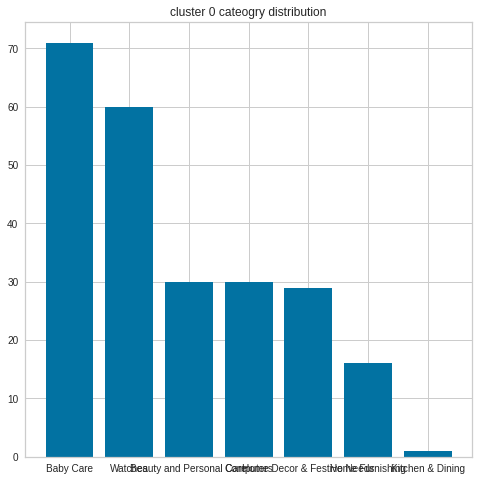

Pour le cluster 1


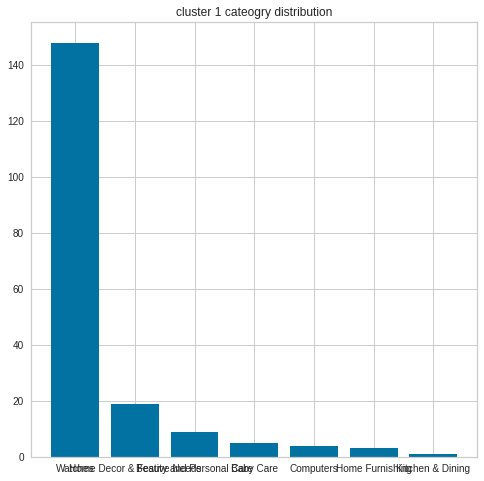

Pour le cluster 2


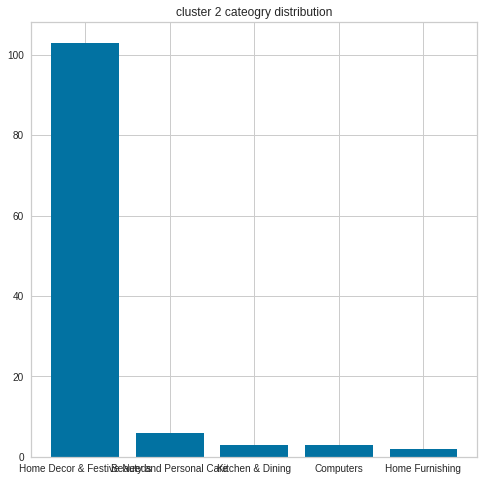

Pour le cluster 3


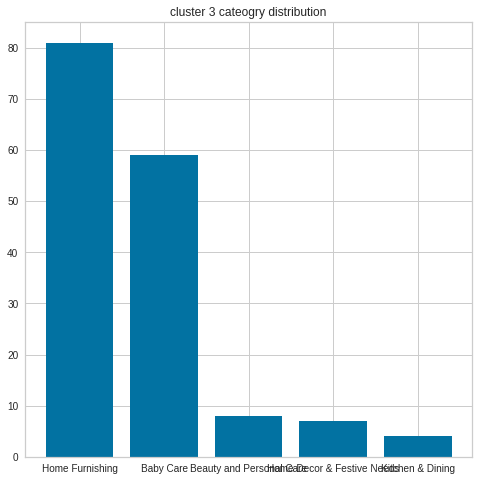

Pour le cluster 4


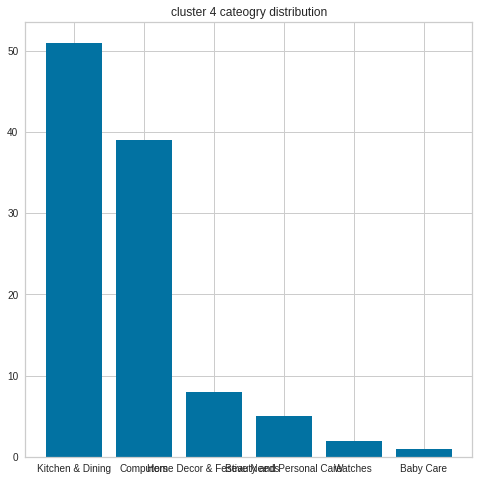

Pour le cluster 5


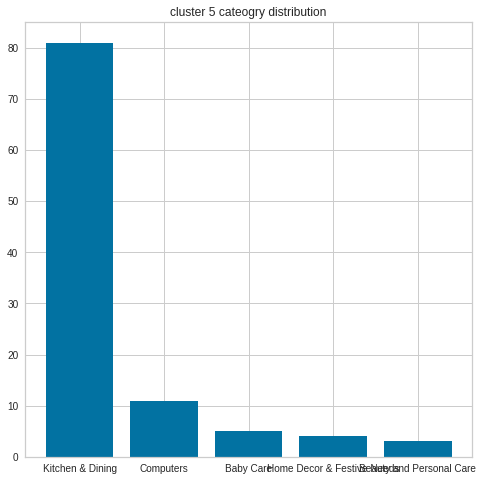

Pour le cluster 6


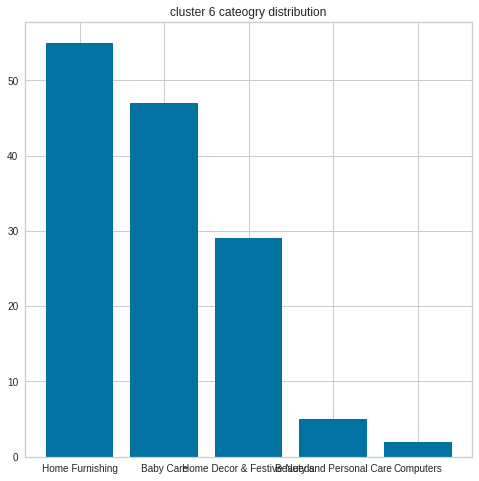

In [ ]:
for i in range(0,7):
  print("Pour le cluster "+str(i))
  l_category = data.loc[data["resnet_cluster_labels"]==i, "product_category_tree"].unique()
  plt.figure(figsize=(8,8))
  plt.bar(l_category,
          data.loc[data["resnet_cluster_labels"]==i, "product_category_tree"].value_counts())
  plt.title(label="cluster "+str(i)+" cateogry distribution")
  plt.show()

Comme pour le NLP, certaines catégories ressortent beaucoup plus.